In [85]:
import sys
sys.path.append("../../XLEMOO")

In [95]:
from XLEMOO.LEMOO import EAParams, MLParams, LEMParams, LEMOO, PastGeneration
from XLEMOO.fitness_indicators import naive_sum, must_sum_to_one, asf_wrapper, single_objective, hypervolume_contribution, inside_ranges
from XLEMOO.tree_interpreter import instantiate_tree_rules, find_all_paths
from XLEMOO.problems import river_pollution_problem
from XLEMOO.plotting import plot_best_fitnesses, plot_mean_fitnesses, plot_std_fitnesses, plot_hypervolume
from XLEMOO.selection import SelectNBest
from desdeo_emo.recombination import SBX_xover, BP_mutation
from desdeo_emo.selection import TournamentSelection
from desdeo_problem.testproblems import test_problem_builder
from desdeo_tools.scalarization.ASF import SimpleASF, GuessASF, StomASF, PointMethodASF
from desdeo_tools.utilities import hypervolume_indicator, epsilon_indicator_ndims, fast_non_dominated_sort_indices
from typing import List

from sklearn.tree import DecisionTreeClassifier
import sklearn.tree as tree
import matplotlib.pyplot as plt
import numpy as np
from imodels import C45TreeClassifier, SlipperClassifier, BoostedRulesClassifier
import imodels

## Define problem

In [96]:
n_objectives = 3
n_variables = 5

problem = test_problem_builder("DTLZ2", n_variables, n_objectives)
# problem = river_pollution_problem()

## Setting model parameters

In [100]:
nadir = np.ones(n_objectives)
ideal = np.zeros(n_objectives)
#ideal = np.array([-6.34, -3.44, -7.5, 0, 0])
#nadir = np.array([-4.75, -2.85, -0.32, 9.70, 0.35])
#ref_point = np.array([-5.0, -3.1, -4.4, 4.2, 0.15])
#guess_asf = asf_wrapper(GuessASF(nadir), {"reference_point": ref_point})

# fitness_fun = lambda x: guess_asf(x) + stom_asf(x) + np.random.uniform(0, 1)

#lower_limits = np.array([-5.5, -3.2, -5.4, 3.2, 0.05])
#upper_limits = np.array([-3.9, -2.9, -0.9, 7.2, 0.20])

lower_limits = np.array([0.3, 0.4, 0.5])
upper_limits = np.array([0.4, 0.5, 0.6])
ref_point = (lower_limits + upper_limits) / 2

inside_ranges_fun = inside_ranges(lower_limits, upper_limits, sim_cost=0.1)
stom_asf = asf_wrapper(StomASF(ideal=ideal), {"reference_point": ref_point})

fitness_fun = lambda x: inside_ranges_fun(x)

# fitness_fun = naive_sum
# fitness_fun = hypervolume_contribution(nadir)

lem_params = LEMParams(
    use_darwin=True,
    use_ml=True,
    fitness_indicator=fitness_fun,
    ml_probe = 1,
    ml_threshold = 0.99999,
    darwin_probe = 5,
    darwin_threshold = 0.99999,
    total_iterations=10
)

ea_params = EAParams(
    population_size=50,
    cross_over_op=SBX_xover(),
    mutation_op=BP_mutation(problem.get_variable_lower_bounds(), problem.get_variable_upper_bounds()),
    # selection_op=TournamentSelection(None, tournament_size=2),
    selection_op=SelectNBest(None, 50),
    population_init_design="LHSDesign",
    iterations_per_cycle=5,
)

# ml = DecisionTreeClassifier(random_state=0, max_depth=5)
ml = SlipperClassifier()
# ml = BoostedRulesClassifier()
ml_params = MLParams(
    H_split=0.3,
    L_split=0.3,
    ml_model=ml,
    instantation_factor=1.0,
    generation_lookback=0,
    iterations_per_cycle=1,
)

## Setup LEMOO model

In [101]:
lemoo = LEMOO(problem, lem_params, ea_params, ml_params)

In [102]:
lemoo.run_iterations()

.
.
.
.
.
.
.
.
.
.


{'darwin_mode': 50, 'learning_mode': 10, 'total_iterations': 10}

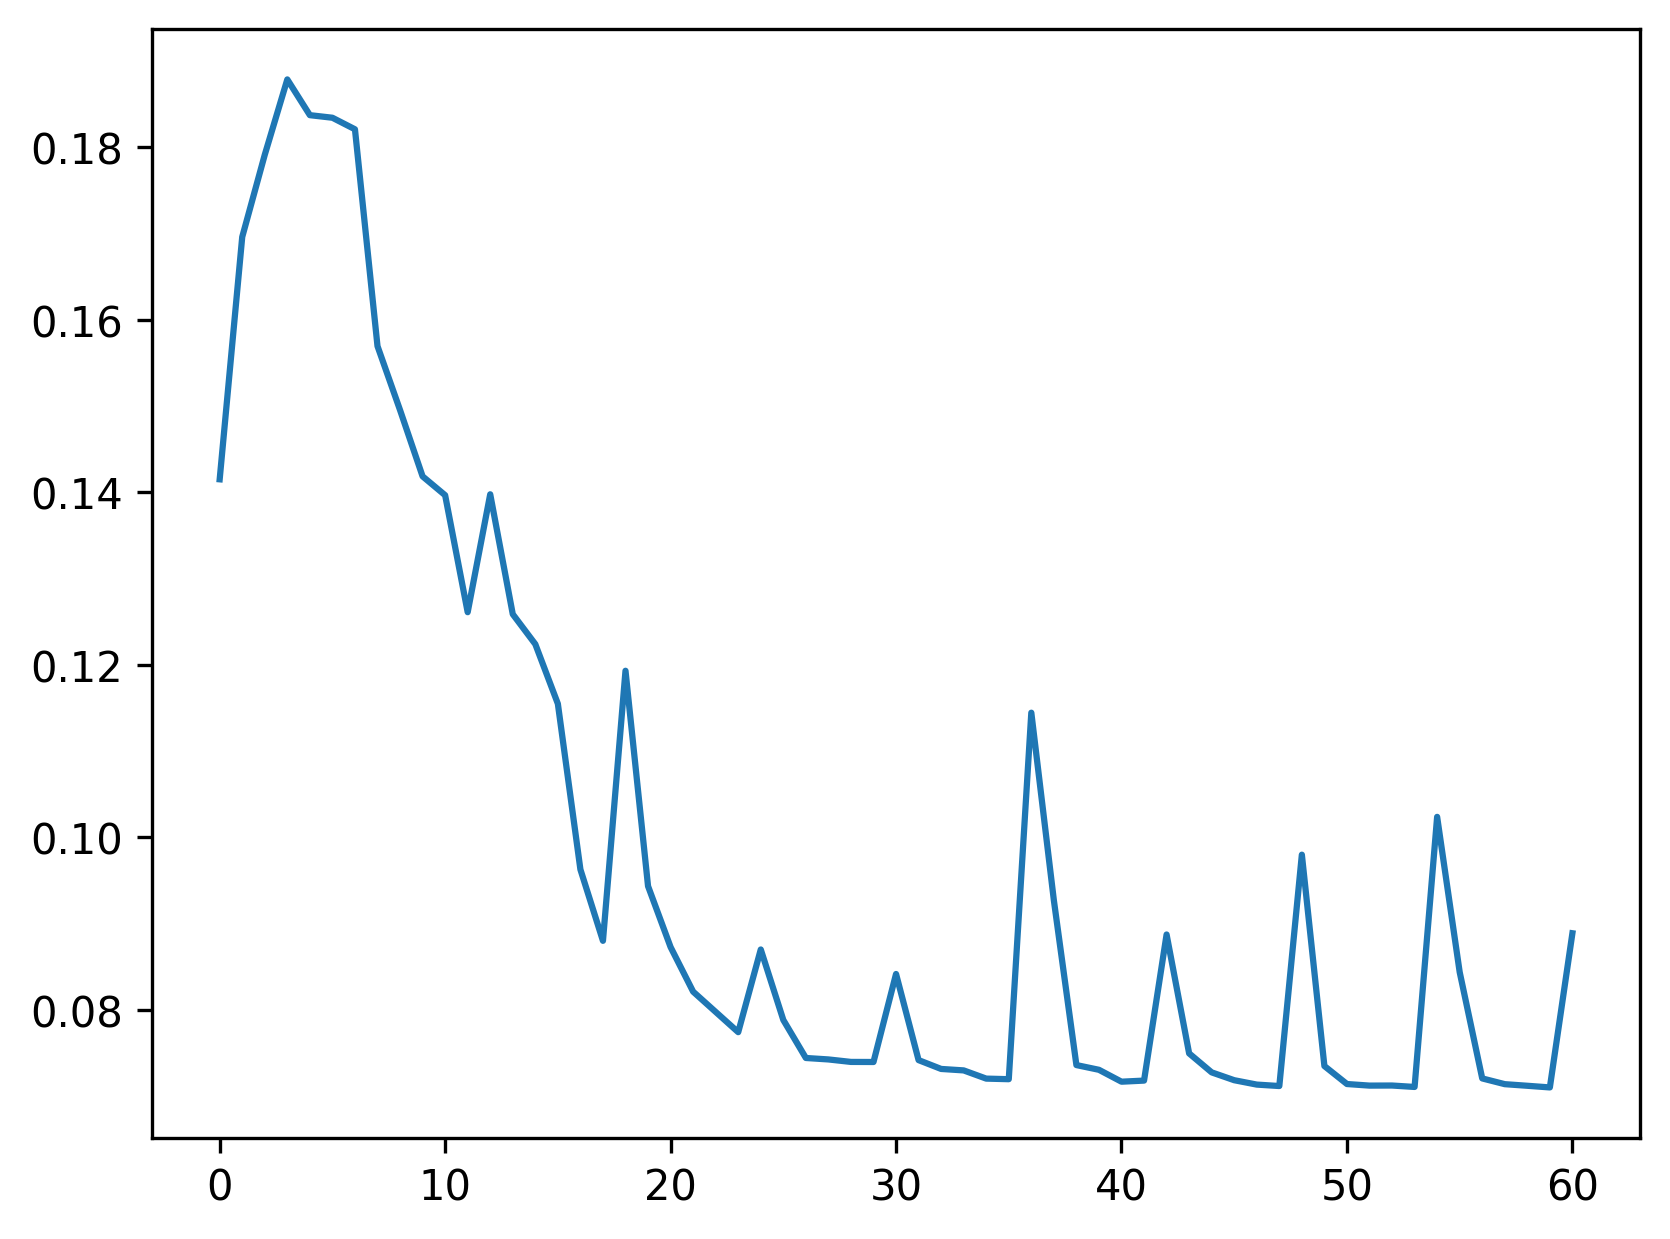

In [103]:
plot_hypervolume(lemoo._generation_history, ref_point=nadir)

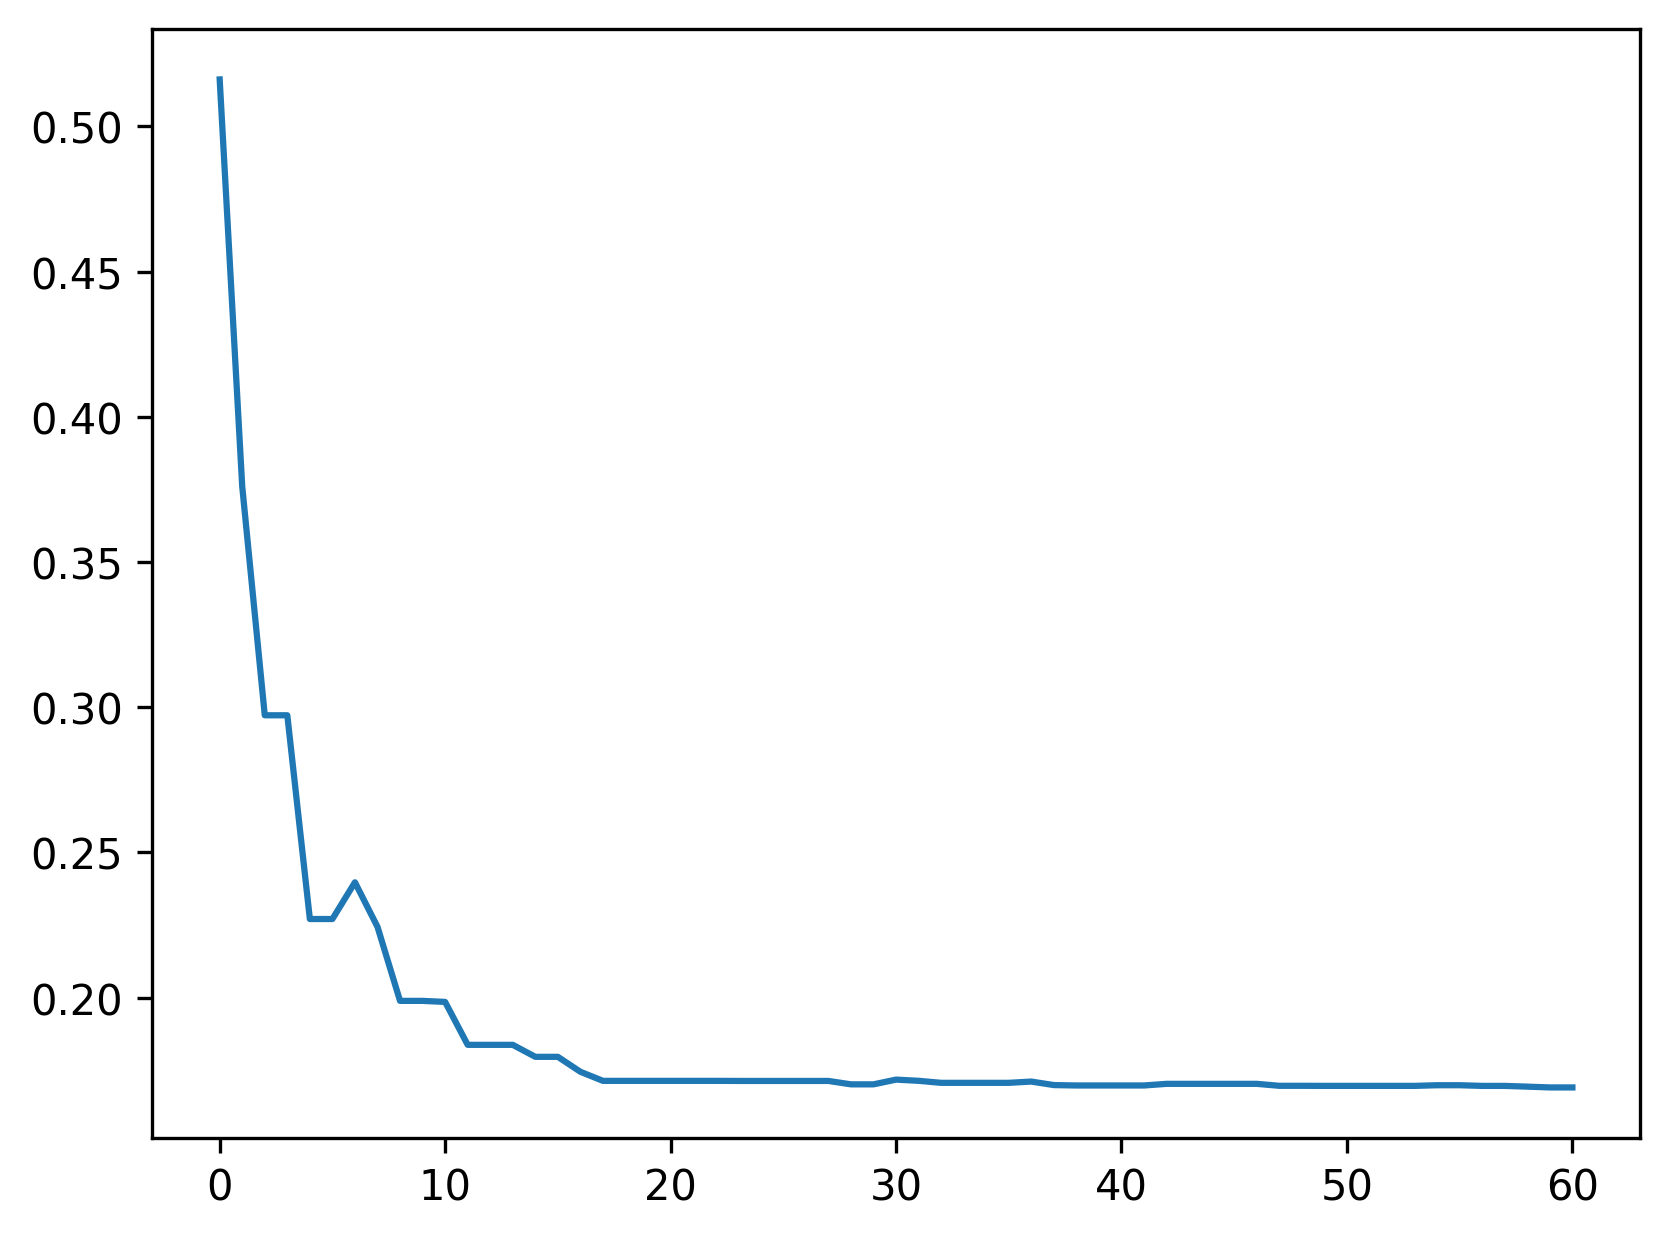

In [104]:
plot_best_fitnesses(lemoo._generation_history)

In [105]:
print(lemoo.current_ml_model)
# tree.plot_tree(lemoo.current_ml_model)

> ------------------------------
> BoostedRules:
> 	Rule → predicted probability (final prediction is weighted sum of all predictions)
> ------------------------------
  If X_1 < 0.5611147049082346 and X_1 > 0.5537468611381298 and X_2 < 0.6128695049543976 and X_2 > 0.5150259123122866 → 0.48 (weight: 2.01)
  If X_1 < 0.5618695692363416 and X_1 > 0.5546086139183576 and X_2 < 0.61270580024991 and X_2 > 0.5139635534475472 → 0.45 (weight: 1.83)
  If X_1 < 0.5614026982596296 and X_1 > 0.550460339116237 and X_2 < 0.6124168657247091 and X_2 > 0.5660047189057329 → 0.47 (weight: 0.55)



In [83]:
problem.evaluate(lemoo._generation_history[-1].individuals[0]).objectives

array([[0.3819083 , 0.54332204, 0.75015376]])

In [84]:
lemoo._generation_history[-1].individuals

array([[0.53868041, 0.60995673, 0.4746181 , 0.48838918, 0.53333003],
       [0.53998109, 0.57742758, 0.44321035, 0.47349385, 0.42806808],
       [0.53428315, 0.61501022, 0.44181183, 0.47346865, 0.42670027],
       [0.53428315, 0.61501022, 0.44181183, 0.47346865, 0.42670027],
       [0.55685384, 0.60125948, 0.50646339, 0.47131364, 0.49229422],
       [0.55685384, 0.60125948, 0.50646339, 0.47131364, 0.49229422],
       [0.51900615, 0.56948608, 0.57316877, 0.41292915, 0.52666127],
       [0.51900615, 0.56948608, 0.57316877, 0.41292915, 0.52666127],
       [0.51900615, 0.56948608, 0.57316877, 0.41292915, 0.52666127],
       [0.53999608, 0.6735243 , 0.44066756, 0.47334962, 0.50572402],
       [0.53999608, 0.6735243 , 0.44066756, 0.47334962, 0.50572402],
       [0.53999608, 0.6735243 , 0.44066756, 0.47334962, 0.50572402],
       [0.46025809, 0.57871555, 0.60654148, 0.48723008, 0.50569119],
       [0.46025809, 0.57871555, 0.60654148, 0.48723008, 0.50569119],
       [0.46025809, 0.57871555, 0.

In [263]:
ref_point

array([-5.  , -3.1 , -4.4 ,  4.2 ,  0.15])

In [264]:
#print(np.logical_and(lemoo._generation_history[-1].objectives_fitnesses <= upper_limits, lemoo._generation_history[-1].objectives_fitnesses >= lower_limits))
a = lemoo._generation_history[-1].objectives_fitnesses[0:3]

fitness_fun(np.atleast_2d(a))

array([0.7535068 , 0.7536178 , 0.75361826])

In [203]:
lower_limits

array([-5.5 , -3.2 , -5.4 ,  3.2 ,  0.05])

In [204]:
upper_limits

array([-3.9, -2.9, -0.9,  7.2,  0.2])

In [205]:
a - lower_limits

array([[-6.47233242e-01, -2.93059738e-02,  4.64601262e-04,
         3.08565316e-05,  2.26947939e-01],
       [-6.47233242e-01, -2.93059738e-02,  4.64601262e-04,
         3.08565316e-05,  2.26947939e-01],
       [-6.47233242e-01, -2.93059738e-02,  4.64601262e-04,
         3.08565316e-05,  2.26947939e-01]])

In [206]:
upper_limits - a

array([[ 2.24723324,  0.32930597,  4.4995354 ,  3.99996914, -0.07694794],
       [ 2.24723324,  0.32930597,  4.4995354 ,  3.99996914, -0.07694794],
       [ 2.24723324,  0.32930597,  4.4995354 ,  3.99996914, -0.07694794]])

In [207]:
lower = np.where(a - lower_limits > 0, 0, np.abs(a - lower_limits))
upper = np.where(upper_limits - a > 0, 0, np.abs(upper_limits - a))

In [208]:
lower

array([[0.64723324, 0.02930597, 0.        , 0.        , 0.        ],
       [0.64723324, 0.02930597, 0.        , 0.        , 0.        ],
       [0.64723324, 0.02930597, 0.        , 0.        , 0.        ]])

In [209]:
upper

array([[0.        , 0.        , 0.        , 0.        , 0.07694794],
       [0.        , 0.        , 0.        , 0.        , 0.07694794],
       [0.        , 0.        , 0.        , 0.        , 0.07694794]])

In [210]:
lower + upper

array([[0.64723324, 0.02930597, 0.        , 0.        , 0.07694794],
       [0.64723324, 0.02930597, 0.        , 0.        , 0.07694794],
       [0.64723324, 0.02930597, 0.        , 0.        , 0.07694794]])

In [211]:
np.sum(lower + upper, axis=1).T

array([0.75348715, 0.75348715, 0.75348715])

In [212]:
fitness_fun(a)

array([0.75348715, 0.75348715, 0.75348715])